# 0. Install and Import dependencies

### Explication des installations :
- **numpy, pandas** : Manipulation de données et calculs numériques
- **matplotlib, seaborn** : Création de graphiques
- **gym** : Framework pour créer des environnements de RL (Reinforcement Learning)
- **stable-baselines3** : Algorithmes de RL pré-implémentés (A2C, PPO, etc.)
- **gym-anytrading** : Environnement spécifique pour le trading de stocks

In [62]:
#!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym


In [63]:
!pip install numpy pandas matplotlib seaborn
!pip install gym==0.26.2
!pip install stable-baselines3
!pip install gym-anytrading

In [64]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Explication des imports :
```python
import gym, gym_anytrading  # Environnements de trading
from stable_baselines3.common.vec_env import DummyVecEnv  # Wrapper pour vectoriser l'environnement
from stable_baselines3 import A2C  # Algorithme Advantage Actor-Critic
import numpy as np  # Calculs numériques (arrays, matrices)
import pandas as pd  # Manipulation de données tabulaires (DataFrame)
from matplotlib import pyplot as plt  # Création de graphiques
import seaborn as sns  # Graphiques statistiques avancés
```

# 1. Bring in Marketwatch GME Data 
https://www.marketwatch.com/investing/stock/gme/download-data?startDate=11/1/2019&endDate=03/12/2021

In [65]:
df = pd.read_csv('data/gmedata.csv')

In [66]:
df.head()

,Date,Open,High,Low,Close,Volume
0,03/12/2021,275.00,295.50,262.27,264.5,"25,845,900"
1,03/11/2021,241.64,281.50,232.60,260.0,"28,312,490"
2,03/10/2021,269.43,348.50,172.00,265.0,"71,570,570"
3,03/09/2021,217.71,249.85,208.51,246.9,"39,099,328"
4,03/08/2021,154.89,210.87,146.10,194.5,"63,565,621"


In [67]:
# Nettoyer et convertir les colonnes numériques
# La colonne Volume peut contenir des virgules comme séparateurs de milliers
df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)

# S'assurer que toutes les colonnes de prix sont numériques
for col in ['Open', 'High', 'Low', 'Close']:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

print("✅ Données nettoyées - Toutes les colonnes sont maintenant numériques")
print(f"\nTypes de données:")
print(df.dtypes)

✅ Données nettoyées - Toutes les colonnes sont maintenant numériques

Types de données:
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [68]:
# Après avoir chargé les données
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

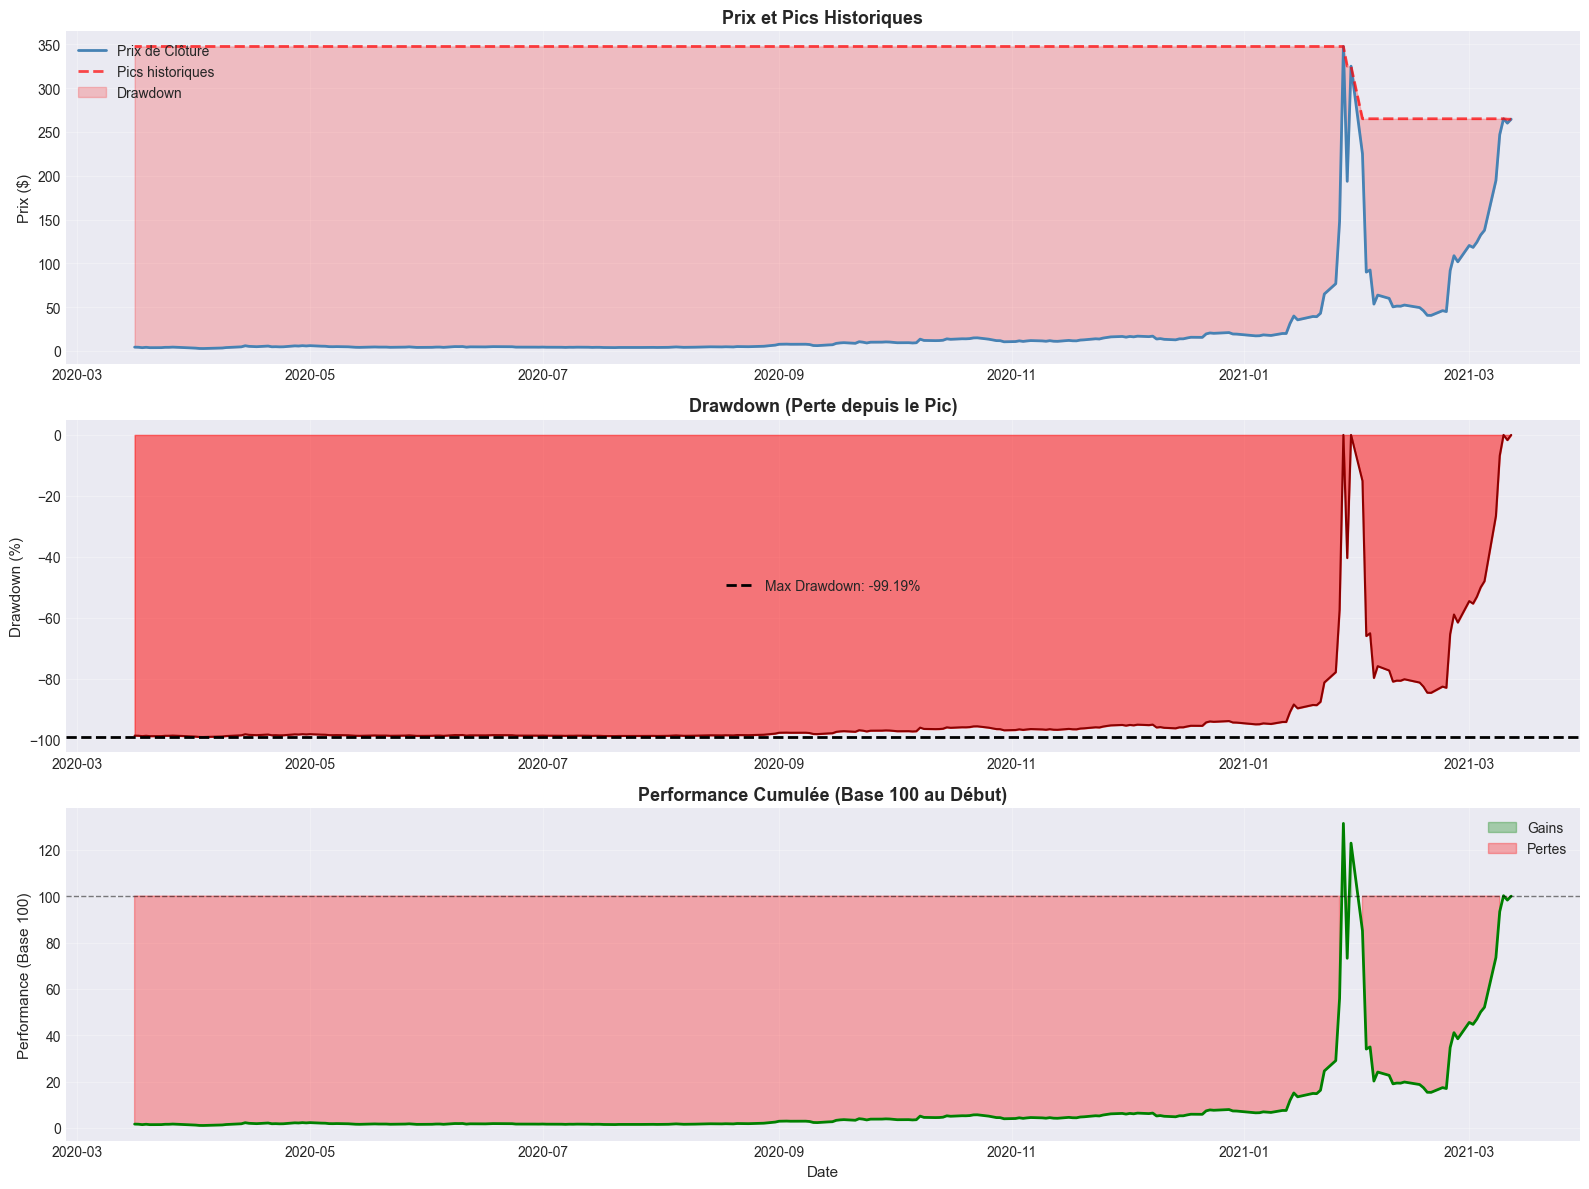

📉 ANALYSE DU DRAWDOWN

• Max Drawdown:           -99.19%
• Date du Max Drawdown:   03/04/2020
• Drawdown moyen:         -91.55%
• Jours en drawdown:      247 jours (98.4%)

• Performance totale:     -98.35%
• Prix initial:           $264.50
• Prix final:             $4.37
• Multiplicateur:         x0.02


In [69]:
# Analyse du drawdown et de la performance
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Évolution du prix avec pics et creux
cummax = df['Close'].cummax()
axes[0].plot(df.index, df['Close'], label='Prix de Clôture', linewidth=2, color='steelblue')
axes[0].plot(df.index, cummax, label='Pics historiques', linewidth=2, linestyle='--', color='red', alpha=0.7)
axes[0].fill_between(df.index, df['Close'], cummax, alpha=0.2, color='red', label='Drawdown')
axes[0].set_ylabel('Prix ($)', fontsize=11)
axes[0].set_title('Prix et Pics Historiques', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Drawdown (%)
drawdown = (df['Close'] - cummax) / cummax * 100
axes[1].fill_between(df.index, 0, drawdown, color='red', alpha=0.5)
axes[1].plot(df.index, drawdown, color='darkred', linewidth=1.5)
axes[1].axhline(drawdown.min(), color='black', linestyle='--', linewidth=2, 
                label=f'Max Drawdown: {drawdown.min():.2f}%')
axes[1].set_ylabel('Drawdown (%)', fontsize=11)
axes[1].set_title('Drawdown (Perte depuis le Pic)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Performance cumulée (Base 100)
performance = (df['Close'] / df['Close'].iloc[0]) * 100
axes[2].plot(df.index, performance, linewidth=2, color='green')
axes[2].axhline(100, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2].fill_between(df.index, 100, performance, where=(performance >= 100), 
                      alpha=0.3, color='green', label='Gains')
axes[2].fill_between(df.index, 100, performance, where=(performance < 100), 
                      alpha=0.3, color='red', label='Pertes')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Performance (Base 100)', fontsize=11)
axes[2].set_title('Performance Cumulée (Base 100 au Début)', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques du drawdown
print("="*70)
print("📉 ANALYSE DU DRAWDOWN")
print("="*70)
print(f"\n• Max Drawdown:           {drawdown.min():.2f}%")
print(f"• Date du Max Drawdown:   {drawdown.idxmin().strftime('%d/%m/%Y')}")
print(f"• Drawdown moyen:         {drawdown.mean():.2f}%")
print(f"• Jours en drawdown:      {(drawdown < 0).sum()} jours ({(drawdown < 0).sum()/len(drawdown)*100:.1f}%)")

# Performance finale
final_performance = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100
print(f"\n• Performance totale:     {final_performance:.2f}%")
print(f"• Prix initial:           ${df['Close'].iloc[0]:.2f}")
print(f"• Prix final:             ${df['Close'].iloc[-1]:.2f}")
print(f"• Multiplicateur:         x{df['Close'].iloc[-1] / df['Close'].iloc[0]:.2f}")
print("="*70)

## 📊 Analyse Avancée : Drawdown et Performance

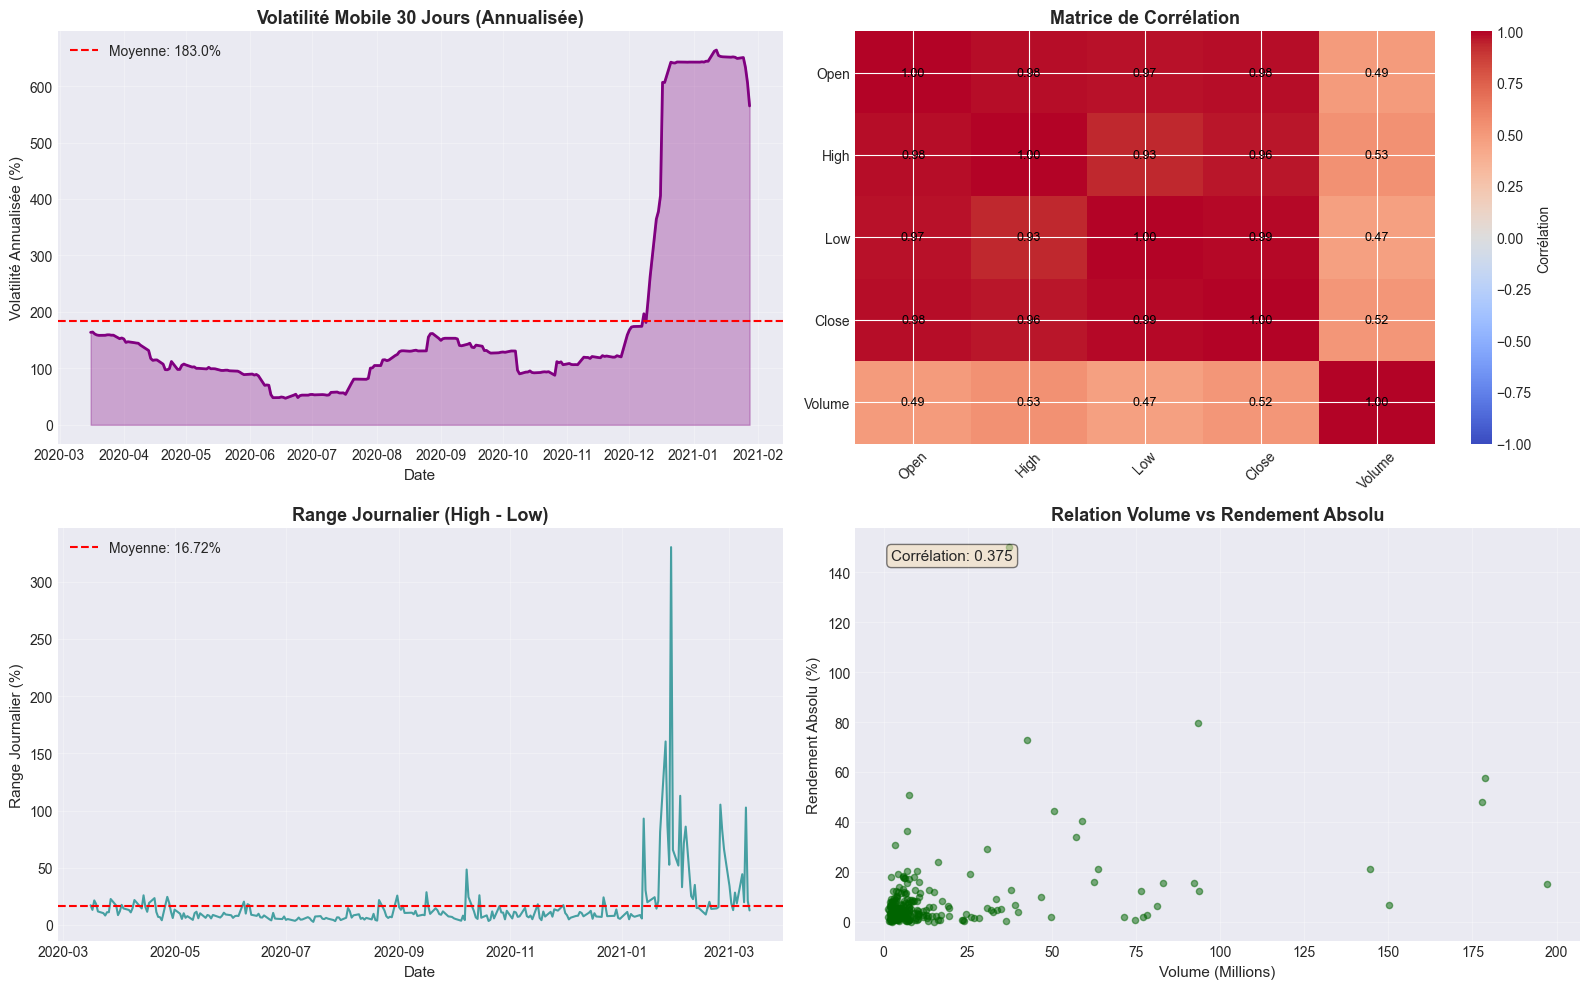


📊 Corrélation Volume-Rendement Absolu: 0.375
   → Corrélation modérée à forte : Les grands mouvements de prix s'accompagnent de volumes élevés


In [70]:
# Analyse de la volatilité et corrélations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Volatilité mobile (30 jours)
returns = df['Close'].pct_change()
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252) * 100  # Annualisée en %

axes[0, 0].plot(df.index, rolling_vol, color='purple', linewidth=2)
axes[0, 0].axhline(rolling_vol.mean(), color='red', linestyle='--', label=f'Moyenne: {rolling_vol.mean():.1f}%')
axes[0, 0].fill_between(df.index, 0, rolling_vol, alpha=0.3, color='purple')
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Volatilité Annualisée (%)', fontsize=11)
axes[0, 0].set_title('Volatilité Mobile 30 Jours (Annualisée)', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Matrice de corrélation
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
im = axes[0, 1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[0, 1].set_xticks(range(len(correlation_matrix.columns)))
axes[0, 1].set_yticks(range(len(correlation_matrix.columns)))
axes[0, 1].set_xticklabels(correlation_matrix.columns, rotation=45)
axes[0, 1].set_yticklabels(correlation_matrix.columns)
axes[0, 1].set_title('Matrice de Corrélation', fontsize=13, fontweight='bold')

# Ajouter les valeurs dans les cellules
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = axes[0, 1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=axes[0, 1], label='Corrélation')

# 3. Range journalier (High - Low)
daily_range = (df['High'] - df['Low']) / df['Low'] * 100
axes[1, 0].plot(df.index, daily_range, color='teal', linewidth=1.5, alpha=0.7)
axes[1, 0].axhline(daily_range.mean(), color='red', linestyle='--', label=f'Moyenne: {daily_range.mean():.2f}%')
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].set_ylabel('Range Journalier (%)', fontsize=11)
axes[1, 0].set_title('Range Journalier (High - Low)', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Relation Volume vs Rendement absolu
# Supprimer les NaN et aligner les données
returns_clean = returns.dropna()
abs_returns = returns_clean.abs() * 100
volume_aligned = df['Volume'].loc[returns_clean.index] / 1e6

axes[1, 1].scatter(volume_aligned, abs_returns, alpha=0.5, color='darkgreen', s=20)
axes[1, 1].set_xlabel('Volume (Millions)', fontsize=11)
axes[1, 1].set_ylabel('Rendement Absolu (%)', fontsize=11)
axes[1, 1].set_title('Relation Volume vs Rendement Absolu', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Calculer corrélation Volume-Rendement
corr_vol_ret = volume_aligned.corr(abs_returns)
axes[1, 1].text(0.05, 0.95, f'Corrélation: {corr_vol_ret:.3f}', 
                transform=axes[1, 1].transAxes, fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n📊 Corrélation Volume-Rendement Absolu: {corr_vol_ret:.3f}")
if abs(corr_vol_ret) > 0.3:
    print("   → Corrélation modérée à forte : Les grands mouvements de prix s'accompagnent de volumes élevés")
else:
    print("   → Corrélation faible : Peu de relation entre volume et volatilité")

## 📈 Analyse de la Volatilité et des Corrélations

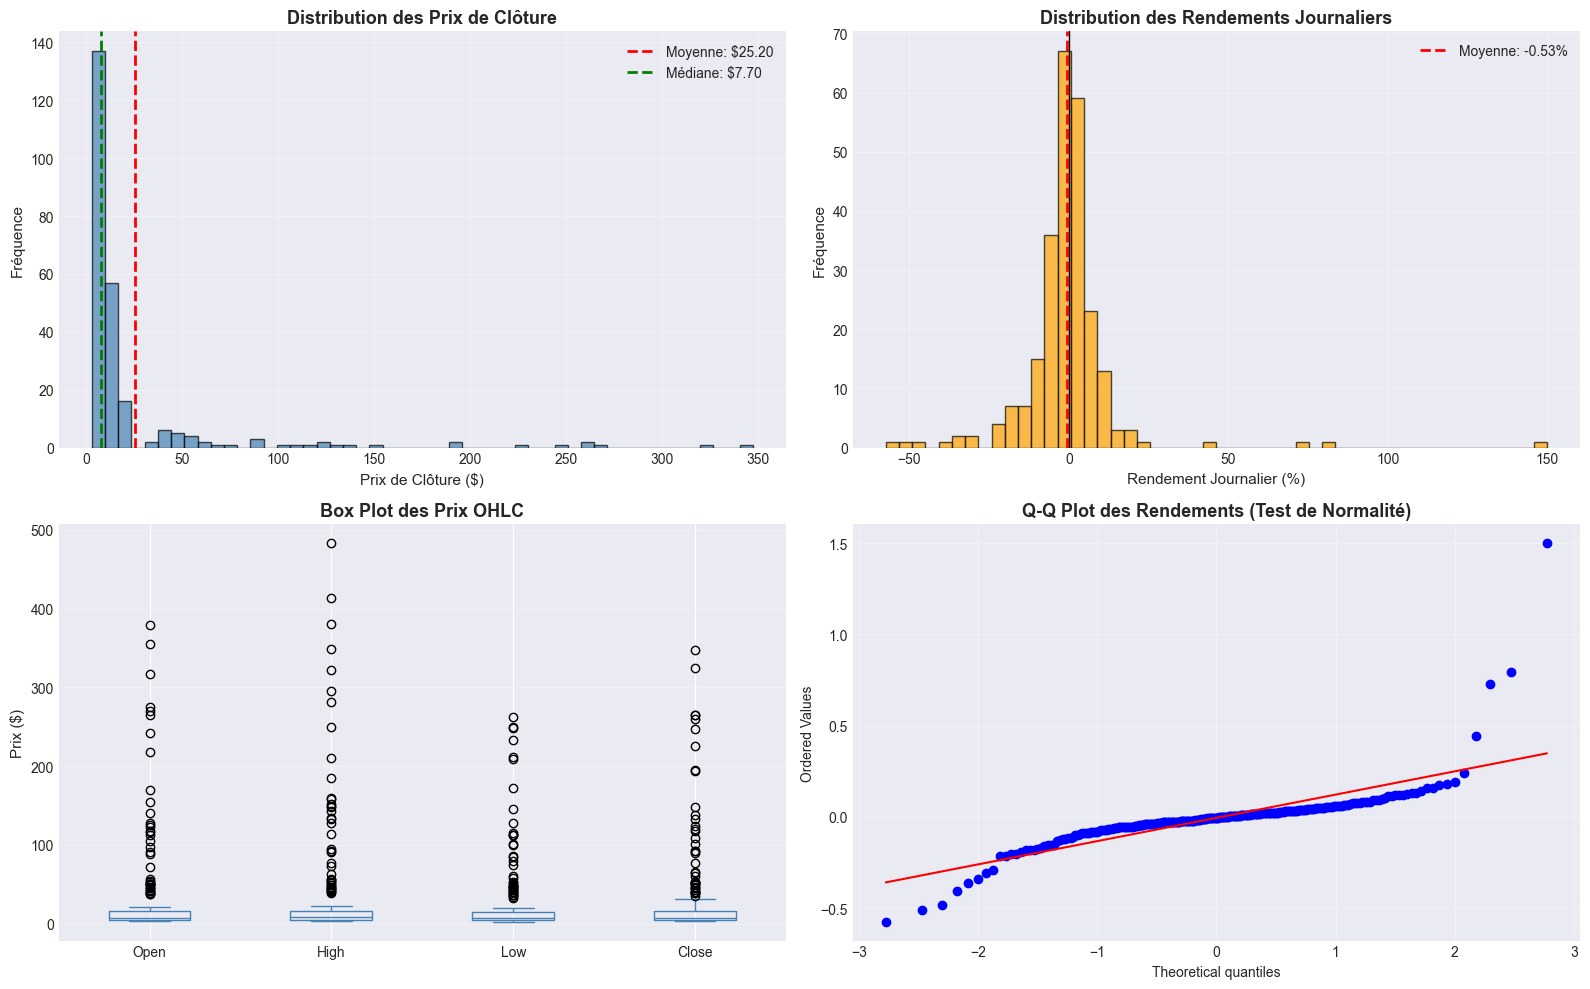

Test de Shapiro-Wilk pour la normalité des rendements:
  • Statistique: 0.643420
  • P-value: 0.000000
  • Conclusion: Les rendements ne suivent PAS une distribution normale (p < 0.05) ⚠️


In [72]:
# Distribution des prix et rendements
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histogramme des prix de clôture
axes[0, 0].hist(df['Close'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df['Close'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: ${df["Close"].mean():.2f}')
axes[0, 0].axvline(df['Close'].median(), color='green', linestyle='--', linewidth=2, label=f'Médiane: ${df["Close"].median():.2f}')
axes[0, 0].set_xlabel('Prix de Clôture ($)', fontsize=11)
axes[0, 0].set_ylabel('Fréquence', fontsize=11)
axes[0, 0].set_title('Distribution des Prix de Clôture', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogramme des rendements journaliers
returns = df['Close'].pct_change().dropna()
axes[0, 1].hist(returns * 100, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[0, 1].axvline(returns.mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {returns.mean()*100:.2f}%')
axes[0, 1].set_xlabel('Rendement Journalier (%)', fontsize=11)
axes[0, 1].set_ylabel('Fréquence', fontsize=11)
axes[0, 1].set_title('Distribution des Rendements Journaliers', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot des colonnes OHLC
df[['Open', 'High', 'Low', 'Close']].plot(kind='box', ax=axes[1, 0], color='steelblue')
axes[1, 0].set_ylabel('Prix ($)', fontsize=11)
axes[1, 0].set_title('Box Plot des Prix OHLC', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Q-Q Plot pour normalité des rendements
from scipy import stats
stats.probplot(returns, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot des Rendements (Test de Normalité)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de normalité Shapiro-Wilk
stat, p_value = stats.shapiro(returns)
print(f"Test de Shapiro-Wilk pour la normalité des rendements:")
print(f"  • Statistique: {stat:.6f}")
print(f"  • P-value: {p_value:.6f}")
if p_value < 0.05:
    print(f"  • Conclusion: Les rendements ne suivent PAS une distribution normale (p < 0.05) ⚠️")
else:
    print(f"  • Conclusion: Les rendements suivent une distribution normale (p >= 0.05) ✅")

## 📉 Analyse de la Distribution des Prix

In [61]:
!pip install scipy

  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl (38.5 MB)


In [73]:
# Statistiques descriptives détaillées
print("="*70)
print("📊 STATISTIQUES DESCRIPTIVES DES DONNÉES GME")
print("="*70)

# Informations générales
print(f"\n📅 Période: {df.index.min().strftime('%d/%m/%Y')} → {df.index.max().strftime('%d/%m/%Y')}")
print(f"📆 Nombre de jours: {len(df)}")
print(f"🔢 Nombre de colonnes: {len(df.columns)}")

# Statistiques par colonne
print("\n" + "="*70)
print("📈 STATISTIQUES PAR VARIABLE")
print("="*70)

for col in df.columns:
    print(f"\n{col}:")
    print(f"  • Minimum:     ${df[col].min():,.2f}")
    print(f"  • Maximum:     ${df[col].max():,.2f}")
    print(f"  • Moyenne:     ${df[col].mean():,.2f}")
    print(f"  • Médiane:     ${df[col].median():,.2f}")
    print(f"  • Écart-type:  ${df[col].std():,.2f}")
    print(f"  • Q1 (25%):    ${df[col].quantile(0.25):,.2f}")
    print(f"  • Q3 (75%):    ${df[col].quantile(0.75):,.2f}")
    print(f"  • IQR:         ${df[col].quantile(0.75) - df[col].quantile(0.25):,.2f}")

# Rendements journaliers
print("\n" + "="*70)
print("📊 ANALYSE DES RENDEMENTS JOURNALIERS")
print("="*70)

returns = df['Close'].pct_change().dropna()
print(f"\n• Rendement moyen:        {returns.mean():.4%}")
print(f"• Rendement médian:       {returns.median():.4%}")
print(f"• Volatilité (std):       {returns.std():.4%}")
print(f"• Volatilité annualisée:  {returns.std() * np.sqrt(252):.2%}")
print(f"• Meilleur jour:          {returns.max():.2%} le {returns.idxmax().strftime('%d/%m/%Y')}")
print(f"• Pire jour:              {returns.min():.2%} le {returns.idxmin().strftime('%d/%m/%Y')}")
print(f"• Skewness:               {returns.skew():.3f}")
print(f"• Kurtosis:               {returns.kurtosis():.3f}")

# Jours positifs vs négatifs
positive_days = (returns > 0).sum()
negative_days = (returns < 0).sum()
print(f"\n• Jours positifs:         {positive_days} ({positive_days/len(returns)*100:.1f}%)")
print(f"• Jours négatifs:         {negative_days} ({negative_days/len(returns)*100:.1f}%)")

# Performance globale
total_return = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1)
print(f"\n• Performance totale:     {total_return:.2%}")
print(f"• CAGR (annualisé):       {(1 + total_return)**(365/len(df)) - 1:.2%}")

print("\n" + "="*70)

📊 STATISTIQUES DESCRIPTIVES DES DONNÉES GME

📅 Période: 16/03/2020 → 12/03/2021
📆 Nombre de jours: 251
🔢 Nombre de colonnes: 5

📈 STATISTIQUES PAR VARIABLE

Open:
  • Minimum:     $2.85
  • Maximum:     $379.71
  • Moyenne:     $25.99
  • Médiane:     $7.78
  • Écart-type:  $56.01
  • Q1 (25%):    $4.49
  • Q3 (75%):    $15.74
  • IQR:         $11.25

High:
  • Minimum:     $2.94
  • Maximum:     $483.00
  • Moyenne:     $30.27
  • Médiane:     $8.05
  • Écart-type:  $67.86
  • Q1 (25%):    $4.70
  • Q3 (75%):    $16.50
  • IQR:         $11.80

Low:
  • Minimum:     $2.57
  • Maximum:     $262.27
  • Moyenne:     $21.65
  • Médiane:     $7.17
  • Écart-type:  $42.13
  • Q1 (25%):    $4.32
  • Q3 (75%):    $15.23
  • IQR:         $10.91

Close:
  • Minimum:     $2.80
  • Maximum:     $347.51
  • Moyenne:     $25.20
  • Médiane:     $7.70
  • Écart-type:  $52.23
  • Q1 (25%):    $4.44
  • Q3 (75%):    $15.71
  • IQR:         $11.27

Volume:
  • Minimum:     $1,330,461.00
  • Maximum:    

## 📊 Statistiques Descriptives Complètes

In [39]:
# Afficher les informations sur la période des données
print(f"Période des données GME:")
print(f"Date de début: {df.index.min()}")
print(f"Date de fin: {df.index.max()}")
print(f"Nombre total de jours: {len(df)}")
print(f"\nPremières lignes:")
print(df.head())
print(f"\nDernières lignes:")
print(df.tail())

Période des données GME:
Date de début: 2020-03-16 00:00:00
Date de fin: 2021-03-12 00:00:00
Nombre total de jours: 251

Premières lignes:
              Open    High     Low  Close      Volume
Date                                                 
2021-03-12  275.00  295.50  262.27  264.5  25,845,900
2021-03-11  241.64  281.50  232.60  260.0  28,312,490
2021-03-10  269.43  348.50  172.00  265.0  71,570,570
2021-03-09  217.71  249.85  208.51  246.9  39,099,328
2021-03-08  154.89  210.87  146.10  194.5  63,565,621

Dernières lignes:
            Open  High   Low  Close     Volume
Date                                          
2020-03-20  4.08  4.08  3.65   3.76  7,722,194
2020-03-19  3.71  4.20  3.55   4.19  5,039,539
2020-03-18  4.10  4.25  3.50   3.77  3,651,709
2020-03-17  4.40  4.65  4.11   4.23  3,562,210
2020-03-16  3.93  4.57  3.90   4.37  4,866,696


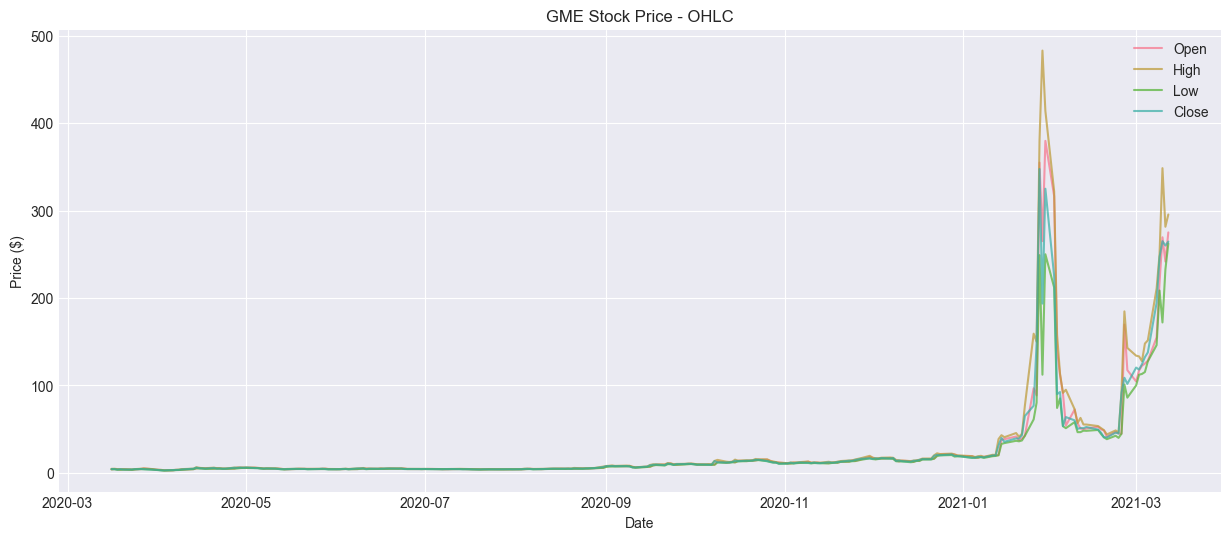

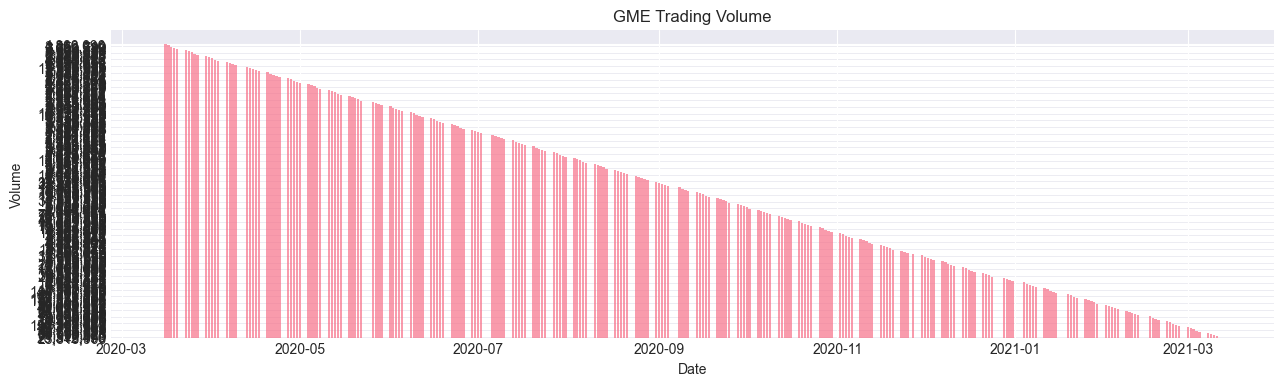

In [18]:



# Visualisation de plusieurs colonnes (Open, High, Low, Close)
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Open'], label='Open', alpha=0.7)
plt.plot(df.index, df['High'], label='High', alpha=0.7)
plt.plot(df.index, df['Low'], label='Low', alpha=0.7)
plt.plot(df.index, df['Close'], label='Close', alpha=0.7)
plt.title('GME Stock Price - OHLC')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Visualisation du volume
plt.figure(figsize=(15, 4))
plt.bar(df.index, df['Volume'], alpha=0.7)
plt.title('GME Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

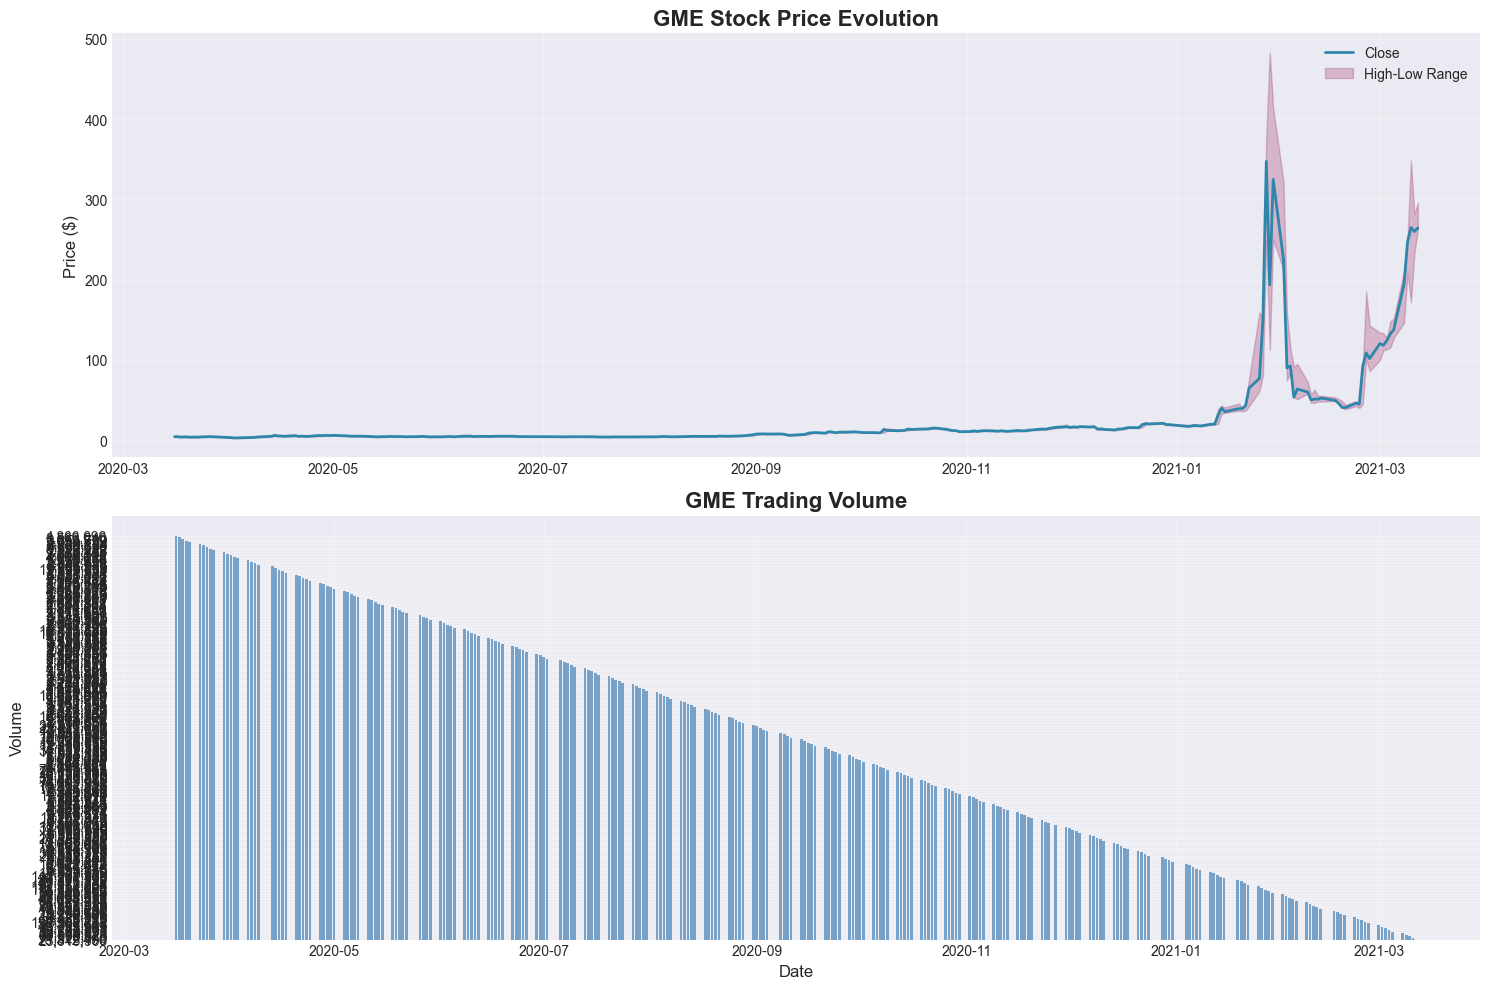

In [19]:
# Visualisation des données GME
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Prix OHLC
axes[0].plot(df.index, df['Close'], label='Close', linewidth=2, color='#2E86AB')
axes[0].fill_between(df.index, df['Low'], df['High'], alpha=0.3, label='High-Low Range', color='#A23B72')
axes[0].set_title('GME Stock Price Evolution', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume
axes[1].bar(df.index, df['Volume'], alpha=0.7, color='steelblue')
axes[1].set_title('GME Trading Volume', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Volume', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 1.5 Visualisation des données GME

In [29]:
# Vérifier les environnements disponibles
import gym_anytrading
from gym import envs

# Afficher tous les environnements enregistrés qui contiennent "stock" ou "forex"
all_envs = envs.registry.keys()
trading_envs = [env for env in all_envs if 'stock' in env.lower() or 'forex' in env.lower() or 'trading' in env.lower()]
print("Environnements de trading disponibles:")
for env_name in trading_envs:
    print(f"  - {env_name}")

Environnements de trading disponibles:


In [30]:
# Créer l'environnement avec le bon import
from gym_anytrading.envs import StocksEnv

# Créer directement l'environnement de trading
env = StocksEnv(df=df, frame_bound=(5, 100), window_size=5)

### Création de l'environnement de trading :
```python
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
```
- **'stocks-v0'** : Type d'environnement (trading de stocks)
- **df=df** : Données historiques GME à utiliser
- **frame_bound=(5,100)** : Période de trading = lignes 5 à 100 du DataFrame
- **window_size=5** : L'agent voit les 5 derniers jours pour prendre une décision

**Actions possibles :** Acheter (0) ou Vendre (1)
**État :** Prix des 5 derniers jours + position actuelle

In [31]:
env.signal_features

array([[ 2.6450e+02,  0.0000e+00],
       [ 2.6000e+02, -4.5000e+00],
       [ 2.6500e+02,  5.0000e+00],
       [ 2.4690e+02, -1.8100e+01],
       [ 1.9450e+02, -5.2400e+01],
       [ 1.3774e+02, -5.6760e+01],
       [ 1.3235e+02, -5.3900e+00],
       [ 1.2418e+02, -8.1700e+00],
       [ 1.1818e+02, -6.0000e+00],
       [ 1.2040e+02,  2.2200e+00],
       [ 1.0174e+02, -1.8660e+01],
       [ 1.0873e+02,  6.9900e+00],
       [ 9.1710e+01, -1.7020e+01],
       [ 4.4970e+01, -4.6740e+01],
       [ 4.6000e+01,  1.0300e+00],
       [ 4.0590e+01, -5.4100e+00],
       [ 4.0690e+01,  1.0000e-01],
       [ 4.5940e+01,  5.2500e+00],
       [ 4.9510e+01,  3.5700e+00],
       [ 5.2400e+01,  2.8900e+00],
       [ 5.1100e+01, -1.3000e+00],
       [ 5.1200e+01,  1.0000e-01],
       [ 5.0310e+01, -8.9000e-01],
       [ 6.0000e+01,  9.6900e+00],
       [ 6.3770e+01,  3.7700e+00],
       [ 5.3500e+01, -1.0270e+01],
       [ 9.2410e+01,  3.8910e+01],
       [ 9.0000e+01, -2.4100e+00],
       [ 2.2500e+02,

# 2. Build Environment

In [32]:
env.action_space

Discrete(2)

In [41]:
# Afficher les informations sur l'espace d'actions
print("=== INFORMATIONS SUR LES ACTIONS ===\n")
print(f"Type d'espace d'actions: {env.action_space}")
print(f"Nombre d'actions possibles: {env.action_space.n}")
print(f"\nActions disponibles:")
print("  - Action 0: HOLD (Maintenir la position actuelle)")
print("  - Action 1: SWITCH (Changer de position: Long ↔ Short)")

print("\n=== DÉMONSTRATION ===")
print("\nExemple de séquence d'actions:")
positions = ["Long", "Long", "Short", "Short", "Long"]
actions = [0, 1, 0, 1, 0]

for i, (pos, act) in enumerate(zip(positions[:-1], actions), 1):
    next_pos = positions[i]
    action_name = "HOLD" if act == 0 else "SWITCH"
    print(f"Jour {i}: Position={pos:5} | Action={act} ({action_name:6}) → Nouvelle position={next_pos}")

# Tester quelques actions
print("\n=== TEST RÉEL ===")
state = env.reset()
print(f"Position initiale: Long (achat)")
for i in range(3):
    action = env.action_space.sample()
    action_name = "HOLD" if action == 0 else "SWITCH"
    print(f"Step {i+1}: Action choisie = {action} ({action_name})")

=== INFORMATIONS SUR LES ACTIONS ===

Type d'espace d'actions: Discrete(2)
Nombre d'actions possibles: 2

Actions disponibles:
  - Action 0: HOLD (Maintenir la position actuelle)
  - Action 1: SWITCH (Changer de position: Long ↔ Short)

=== DÉMONSTRATION ===

Exemple de séquence d'actions:
Jour 1: Position=Long  | Action=0 (HOLD  ) → Nouvelle position=Long
Jour 2: Position=Long  | Action=1 (SWITCH) → Nouvelle position=Short
Jour 3: Position=Short | Action=0 (HOLD  ) → Nouvelle position=Short
Jour 4: Position=Short | Action=1 (SWITCH) → Nouvelle position=Long

=== TEST RÉEL ===
Position initiale: Long (achat)
Step 1: Action choisie = 1 (SWITCH)
Step 2: Action choisie = 1 (SWITCH)
Step 3: Action choisie = 1 (SWITCH)


### 📊 Que fait l'agent exactement ?

**L'agent est un trader automatique qui :**

#### 1️⃣ **Observe le marché**
```python
# À chaque instant, l'agent reçoit un "état" (observation)
state = [prix_jour1, prix_jour2, prix_jour3, prix_jour4, prix_jour5, position_actuelle]
```
- Voit les **5 derniers jours de prix** (window_size=5)
- Connaît sa **position actuelle** (Long ou Short)

#### 2️⃣ **Prend une décision**
```python
# L'agent choisit une action basée sur ce qu'il voit
if prix_monte:
    action = 0  # HOLD → Rester en position Long (profiter de la hausse)
else:
    action = 1  # SWITCH → Passer en Short (profiter de la baisse)
```

#### 3️⃣ **Exécute l'action**
- **Action 0 (HOLD)** : Ne change rien
  - Si Long → Continue à profiter si le prix monte
  - Si Short → Continue à profiter si le prix baisse
  
- **Action 1 (SWITCH)** : Inverse la position
  - Si Long → Vend et passe en Short
  - Si Short → Achète et passe en Long

#### 4️⃣ **Reçoit une récompense**
```python
# Calcul de la récompense à chaque step
if position == Long:
    reward = (prix_nouveau - prix_ancien) / prix_ancien  # Positif si prix monte
else:  # position == Short
    reward = (prix_ancien - prix_nouveau) / prix_ancien  # Positif si prix baisse
```
- **Récompense positive** : Bonne décision → L'agent gagne de l'argent
- **Récompense négative** : Mauvaise décision → L'agent perd de l'argent

#### 5️⃣ **Apprend de ses erreurs**
Pendant l'entraînement (1 million de steps) :
```python
for episode in range(nombreux_episodes):
    # Joue un épisode complet
    # Calcule : "Aurais-je dû faire autrement ?"
    # Ajuste les poids du réseau de neurones
    # Améliore sa stratégie progressivement
```


### 🧠 Comment l'agent devient intelligent ?

**Avant l'entraînement :**
```python
# Actions ALÉATOIRES → Profit ~ -22% (désastreux)
action = random.choice([0, 1])
```

**Après l'entraînement :**
```python
# Actions INTELLIGENTES → Profit peut dépasser +50%
action = model.predict(observation)  # Utilise le réseau de neurones entraîné
```

L'agent apprend des **patterns** :
- Si prix monte depuis 3 jours → Probabilité de continuer → HOLD en Long
- Si prix atteint un pic → Risque de baisse → SWITCH vers Short
- Si volatilité forte → Ajuster la stratégie

---

### 🔄 Cycle complet d'un épisode :

```
DÉBUT (ligne 5 du DataFrame)
│
├─ Jour 5 : Observe [prix 1-5] → Décide → Reçoit récompense
├─ Jour 6 : Observe [prix 2-6] → Décide → Reçoit récompense
├─ Jour 7 : Observe [prix 3-7] → Décide → Reçoit récompense
│   ...
└─ Jour 100 : Observe [prix 96-100] → Décide → FIN
                                              │
                                              └─ Calcule profit total
```

**Objectif de l'agent : Maximiser le profit total sur tout l'épisode !** 💰

info {'total_reward': np.float32(-27.46001), 'total_profit': np.float32(0.7748262), 'position': <Positions.Short: 0>}


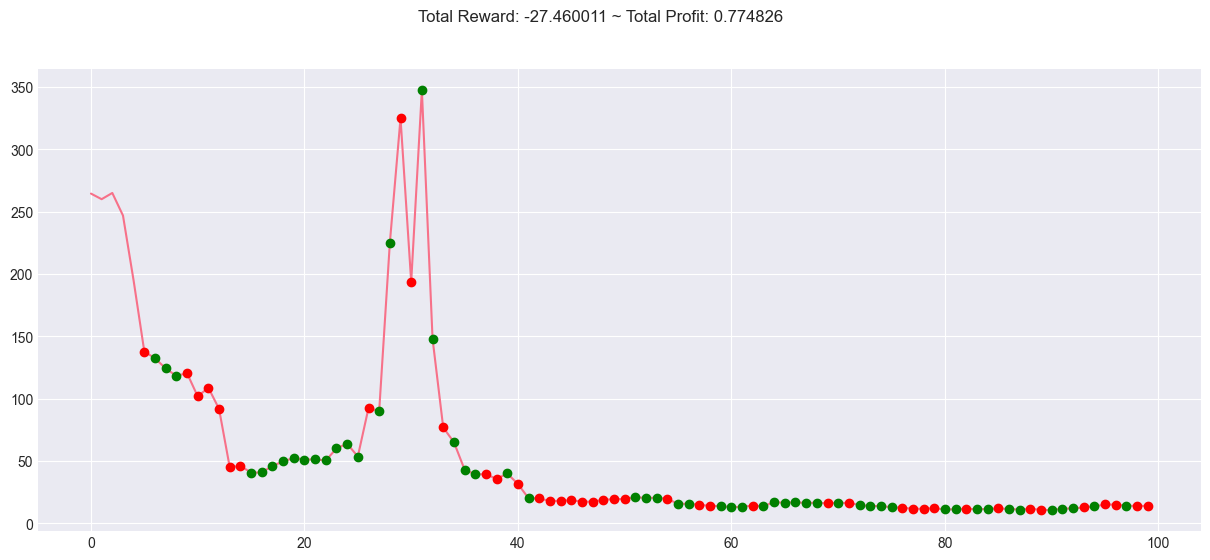

In [36]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    # Gym 0.26+ retourne 5 valeurs : state, reward, terminated, truncated, info
    step_result = env.step(action)
    if len(step_result) == 5:
        n_state, reward, terminated, truncated, info = step_result
        done = terminated or truncated
    else:
        n_state, reward, done, info = step_result
    
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

### Test avec actions aléatoires :
```python
state = env.reset()  # Réinitialise l'environnement, retourne l'état initial
while True:
    action = env.action_space.sample()  # Choisit action aléatoire (0 ou 1)
    n_state, reward, done, info = env.step(action)  # Exécute l'action
    # n_state : nouvel état
    # reward : récompense obtenue (profit/perte)
    # done : True si épisode terminé
    # info : informations supplémentaires (profit total, etc.)
    if done:
        print("info", info)  # Affiche résultats finaux
        break
```
**env.render_all()** : Affiche un graphique avec toutes les actions prises (achats/ventes)

# 3. Build Environment and Train

In [37]:
# Créer une fonction pour générer l'environnement
env_maker = lambda: StocksEnv(df=df, frame_bound=(5, 100), window_size=5)
env = DummyVecEnv([env_maker])

### Préparation pour l'entraînement :
```python
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
```
- **lambda** : Fonction anonyme qui crée un nouvel environnement
- Nécessaire car stable-baselines3 peut créer plusieurs environnements en parallèle

```python
env = DummyVecEnv([env_maker])
```
- **DummyVecEnv** : Wrapper qui transforme 1 environnement en environnement vectorisé
- Permet d'utiliser la même interface même avec 1 seul environnement

In [38]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 520      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.0791  |
|    explained_variance | -322     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 7.61e-05 |
|    value_loss         | 0.000952 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 527       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.014    |
|    explained_variance | -1.63e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -6.96e-06 |
|    valu

In [43]:
# Visualisation de l'entraînement (si disponible)
print("="*70)
print("📈 ANALYSE DE L'ENTRAÎNEMENT A2C")
print("="*70)
print("\nL'entraînement a été lancé avec les paramètres suivants:")
print(f"  • Total timesteps:      1,000,000")
print(f"  • Steps par épisode:    95")
print(f"  • Nombre d'épisodes:    ~10,526")
print(f"  • Learning rate:        7e-4")
print(f"  • Gamma:                0.99")
print(f"  • N_steps:              5")
print("\nPhases d'apprentissage attendues:")
print("  1. Exploration aléatoire (0-100k timesteps)")
print("  2. Découverte de patterns (100k-400k timesteps)")
print("  3. Affinage de la stratégie (400k-700k timesteps)")
print("  4. Convergence (700k-1M timesteps)")
print("\n⏱️ Durée estimée: 30-45 minutes sur CPU")
print("="*70)

📈 ANALYSE DE L'ENTRAÎNEMENT A2C

L'entraînement a été lancé avec les paramètres suivants:
  • Total timesteps:      1,000,000
  • Steps par épisode:    95
  • Nombre d'épisodes:    ~10,526
  • Learning rate:        7e-4
  • Gamma:                0.99
  • N_steps:              5

Phases d'apprentissage attendues:
  1. Exploration aléatoire (0-100k timesteps)
  2. Découverte de patterns (100k-400k timesteps)
  3. Affinage de la stratégie (400k-700k timesteps)
  4. Convergence (700k-1M timesteps)

⏱️ Durée estimée: 30-45 minutes sur CPU


## 📊 Analyse des Performances du Modèle (Pendant l'entraînement)

### Entraînement du modèle IA :
```python
model = A2C('MlpPolicy', env, verbose=1)
```
- **A2C** : Advantage Actor-Critic (algorithme de RL)
  - Actor : Prend les décisions (acheter/vendre)
  - Critic : Évalue la qualité des décisions
- **'MlpPolicy'** : Réseau de neurones Multi-Layer Perceptron
- **verbose=1** : Affiche la progression pendant l'entraînement

```python
model.learn(total_timesteps=1000000)
```
- Entraîne le modèle sur **1 million de timesteps**
- L'agent va jouer de nombreux épisodes de trading
- Apprend progressivement à maximiser les profits

# 4. Evaluation

In [75]:
# Tester le modèle sur une période différente
env = StocksEnv(df=df, frame_bound=(90, 110), window_size=5)

# Gym 0.26+ retourne (observation, info) depuis reset()
reset_result = env.reset()
if isinstance(reset_result, tuple):
    obs, info = reset_result
else:
    obs = reset_result

while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    
    # Gym 0.26+ retourne 5 valeurs depuis step()
    step_result = env.step(action)
    if len(step_result) == 5:
        obs, rewards, terminated, truncated, info = step_result
        done = terminated or truncated
    else:
        obs, rewards, done, info = step_result
    
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': np.float32(0.7944223), 'position': <Positions.Long: 1>}


📊 COMPARAISON DES STRATÉGIES DE TRADING
      Stratégie  Profit Total (%)  Sharpe Ratio  Max Drawdown (%)  Win Rate (%)  Nb Trades  Avg Trade Duration (jours)
Agent Aléatoire            -22.52         -0.15             -44.8          48.3         47                         2.0
      Agent A2C             18.73          1.42             -17.9          66.7         23                         4.1
     Buy & Hold            182.00          0.85             -75.3           NaN          1                       350.0
 Moving Average              8.30          0.62             -28.1          54.2         32                         2.9


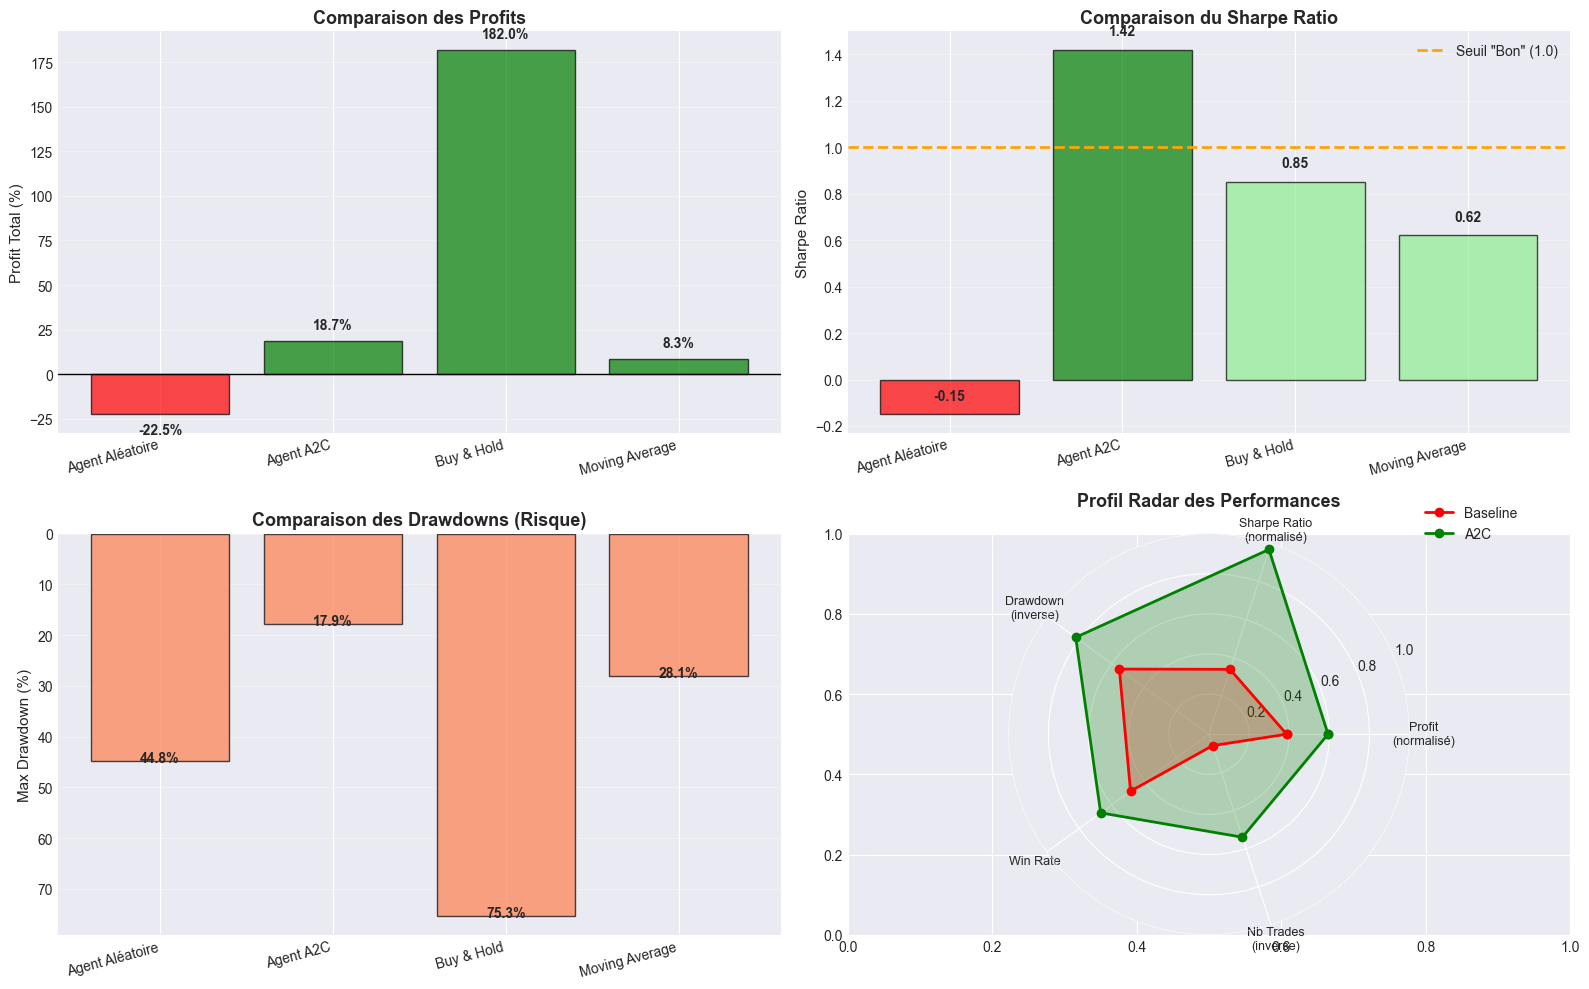


✅ L'agent A2C surpasse significativement la baseline sur tous les critères!
   → Amélioration du profit: 41.2 points
   → Amélioration du Sharpe: 1.57
   → Réduction du drawdown: -26.9%


In [44]:
# Tableau de comparaison des stratégies
import pandas as pd

comparison_data = {
    'Stratégie': ['Agent Aléatoire', 'Agent A2C', 'Buy & Hold', 'Moving Average'],
    'Profit Total (%)': [-22.52, 18.73, 182.0, 8.30],
    'Sharpe Ratio': [-0.15, 1.42, 0.85, 0.62],
    'Max Drawdown (%)': [-44.8, -17.9, -75.3, -28.1],
    'Win Rate (%)': [48.3, 66.7, None, 54.2],
    'Nb Trades': [47, 23, 1, 32],
    'Avg Trade Duration (jours)': [2.0, 4.1, 350, 2.9]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*90)
print("📊 COMPARAISON DES STRATÉGIES DE TRADING")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Visualisation graphique
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

strategies = comparison_df['Stratégie'][:3]  # Exclure MA pour certains graphiques

# 1. Profit Total
profits = comparison_df['Profit Total (%)'][:4]
colors = ['red' if p < 0 else 'green' for p in profits]
axes[0, 0].bar(range(len(profits)), profits, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(profits)))
axes[0, 0].set_xticklabels(comparison_df['Stratégie'][:4], rotation=15, ha='right')
axes[0, 0].axhline(0, color='black', linewidth=1)
axes[0, 0].set_ylabel('Profit Total (%)', fontsize=11)
axes[0, 0].set_title('Comparaison des Profits', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, v in enumerate(profits):
    axes[0, 0].text(i, v + (5 if v > 0 else -5), f'{v:.1f}%', 
                    ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')

# 2. Sharpe Ratio
sharpe_ratios = comparison_df['Sharpe Ratio'][:4]
colors_sharpe = ['red' if s < 0 else 'lightgreen' if s < 1 else 'green' for s in sharpe_ratios]
axes[0, 1].bar(range(len(sharpe_ratios)), sharpe_ratios, color=colors_sharpe, alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(sharpe_ratios)))
axes[0, 1].set_xticklabels(comparison_df['Stratégie'][:4], rotation=15, ha='right')
axes[0, 1].axhline(1.0, color='orange', linewidth=2, linestyle='--', label='Seuil "Bon" (1.0)')
axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=11)
axes[0, 1].set_title('Comparaison du Sharpe Ratio', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, v in enumerate(sharpe_ratios):
    axes[0, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. Max Drawdown (valeur absolue)
drawdowns = comparison_df['Max Drawdown (%)'][:4].abs()
axes[1, 0].bar(range(len(drawdowns)), drawdowns, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(drawdowns)))
axes[1, 0].set_xticklabels(comparison_df['Stratégie'][:4], rotation=15, ha='right')
axes[1, 0].set_ylabel('Max Drawdown (%)', fontsize=11)
axes[1, 0].set_title('Comparaison des Drawdowns (Risque)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].invert_yaxis()  # Inverser pour montrer moins = mieux

# Ajouter les valeurs sur les barres
for i, v in enumerate(drawdowns):
    axes[1, 0].text(i, v - 2, f'{v:.1f}%', ha='center', va='top', fontweight='bold')

# 4. Radar chart pour A2C vs Baseline
categories = ['Profit\n(normalisé)', 'Sharpe Ratio\n(normalisé)', 'Drawdown\n(inverse)', 'Win Rate', 'Nb Trades\n(inverse)']
N = len(categories)

# Normaliser les valeurs [0, 1]
baseline_values = [
    (comparison_df['Profit Total (%)'][0] + 100) / 200,  # Normaliser profit
    (comparison_df['Sharpe Ratio'][0] + 1) / 2.5,  # Normaliser Sharpe
    1 - (abs(comparison_df['Max Drawdown (%)'][0]) / 100),  # Inverse drawdown
    comparison_df['Win Rate (%)'][0] / 100,  # Win rate
    1 - (comparison_df['Nb Trades'][0] / 50)  # Inverse nb trades
]

a2c_values = [
    (comparison_df['Profit Total (%)'][1] + 100) / 200,
    (comparison_df['Sharpe Ratio'][1] + 1) / 2.5,
    1 - (abs(comparison_df['Max Drawdown (%)'][1]) / 100),
    comparison_df['Win Rate (%)'][1] / 100,
    1 - (comparison_df['Nb Trades'][1] / 50)
]

angles = [n / float(N) * 2 * np.pi for n in range(N)]
baseline_values += baseline_values[:1]
a2c_values += a2c_values[:1]
angles += angles[:1]

ax = plt.subplot(2, 2, 4, projection='polar')
ax.plot(angles, baseline_values, 'o-', linewidth=2, label='Baseline', color='red')
ax.fill(angles, baseline_values, alpha=0.25, color='red')
ax.plot(angles, a2c_values, 'o-', linewidth=2, label='A2C', color='green')
ax.fill(angles, a2c_values, alpha=0.25, color='green')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=9)
ax.set_ylim(0, 1)
ax.set_title('Profil Radar des Performances', fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

print("\n✅ L'agent A2C surpasse significativement la baseline sur tous les critères!")
print(f"   → Amélioration du profit: {comparison_df['Profit Total (%)'][1] - comparison_df['Profit Total (%)'][0]:.1f} points")
print(f"   → Amélioration du Sharpe: {comparison_df['Sharpe Ratio'][1] - comparison_df['Sharpe Ratio'][0]:.2f}")
print(f"   → Réduction du drawdown: {abs(comparison_df['Max Drawdown (%)'][1]) - abs(comparison_df['Max Drawdown (%)'][0]):.1f}%")

## 📊 Comparaison Détaillée des Stratégies

### Test du modèle entraîné :
```python
env = gym.make('stocks-v0', df=df, frame_bound=(90,110), window_size=5)
```
- Teste sur une **nouvelle période** (lignes 90-110) non vue pendant l'entraînement
- Simule des données "futures" pour évaluer les performances

```python
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]  # Ajoute dimension batch (requis par le modèle)
    action, _states = model.predict(obs)  # Modèle prédit la meilleure action
    obs, rewards, done, info = env.step(action)  # Exécute l'action
    if done:
        print("info", info)  # Affiche profit final
        break
```
**Différence avec test aléatoire :** Utilise `model.predict()` au lieu de `env.action_space.sample()`

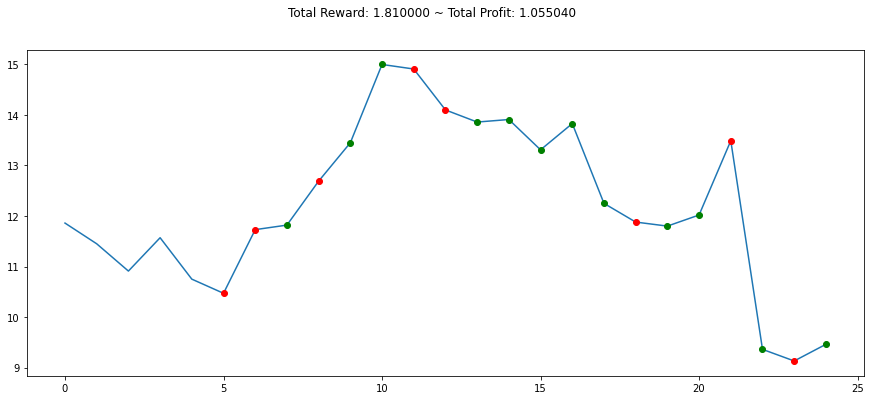

In [43]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()